In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, window1, window2):

    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['ma1'] = np.nan
    signals['ma2'] = np.nan
    signals['macd'] = np.nan
    signals['positions'] = 0

    for i in range(max(window1, window2), len(signals)):
        signals.at[signals.index[i], 'ma1'] = (signals['asset'].iloc[i-min(window1, window2):i]).ewm(alpha=2.0/(1 + min(window1, window2))).mean().iloc[-1]
        signals.at[signals.index[i], 'ma2'] = (signals['asset'].iloc[i-max(window1, window2):i]).ewm(alpha=2.0/(1 + max(window1, window2))).mean().iloc[-1]
        signals.at[signals.index[i], 'macd'] = signals['ma1'].iloc[i] - signals['ma2'].iloc[i]

        if (signals['macd'].iloc[i-9:i]).ewm(alpha=0.2).mean().iloc[-1] >= 0:
            signals.at[signals.index[i], 'positions'] = 1
        else:
            signals.at[signals.index[i], 'positions'] = -1
        
    signals['signals'] = signals['positions'].diff()
    signals['oscillator'] = signals['ma1'] - signals['ma2']
    return signals

In [3]:
def plot(signals, ticker):
    
    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, alpha=0.8, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('MACD', pad=15)
    plt.grid(True)
    plt.show()
    
    # Running oscillator
    fig=plt.figure(figsize=(11,7))
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
    ax.plot(signals['ma1'], color='C0', alpha=0.8, label='Short Term')
    ax.plot(signals['ma2'], color='C1', alpha=0.8, label='Long Term')
    ax2.bar(signals.index, signals['oscillator'], color='r', alpha=0.2, label='Oscillator')
    ax.set_ylabel("Moving Average", labelpad=15)
    ax2.set_ylabel("Difference", rotation=270, labelpad=15)
    ax.set_xlabel('Date', labelpad=15)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title('MACD', pad=15)
    plt.show()

In [4]:
def MACD(ticker, start_date, end_date, capital):

    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Default windows of 12 and 26 days
    signals = signal_generation(asset, 12, 26)
    
    plot(signals, ticker)

    return stats(portfolio(signals, capital, 'MACD'), signals, start_date, end_date, capital)

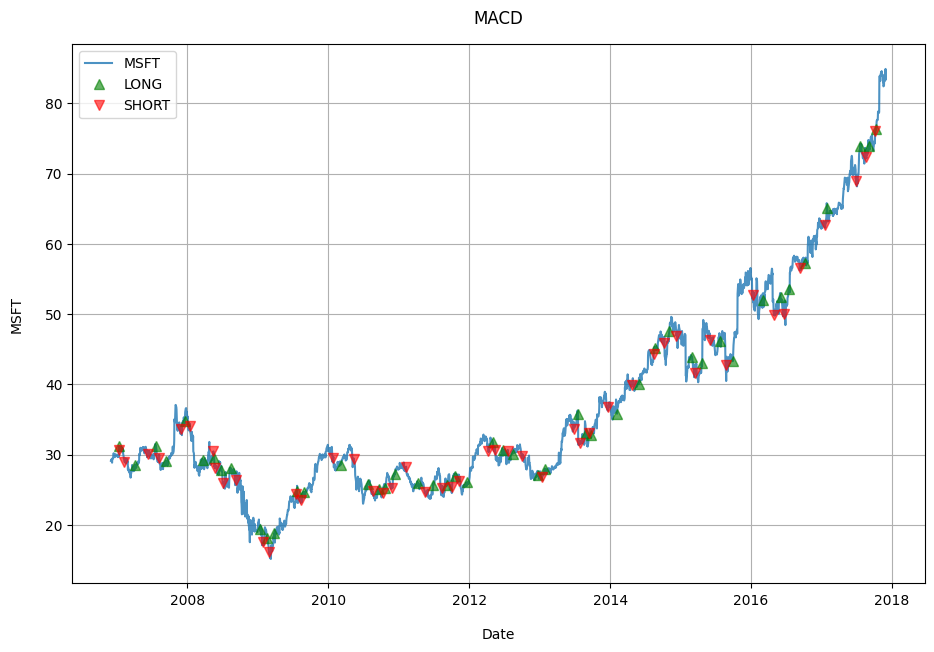

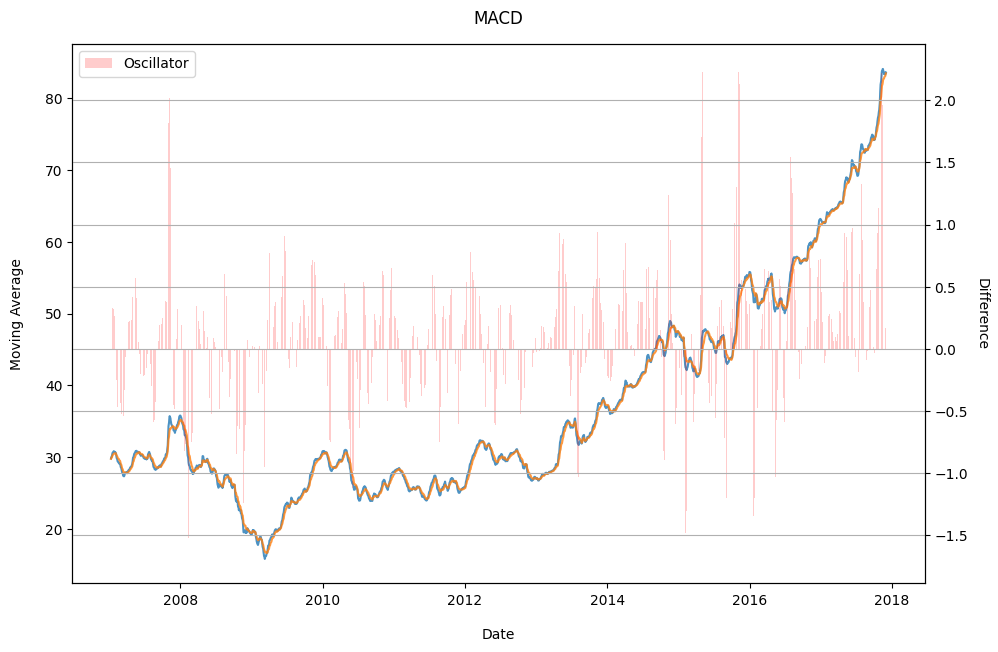

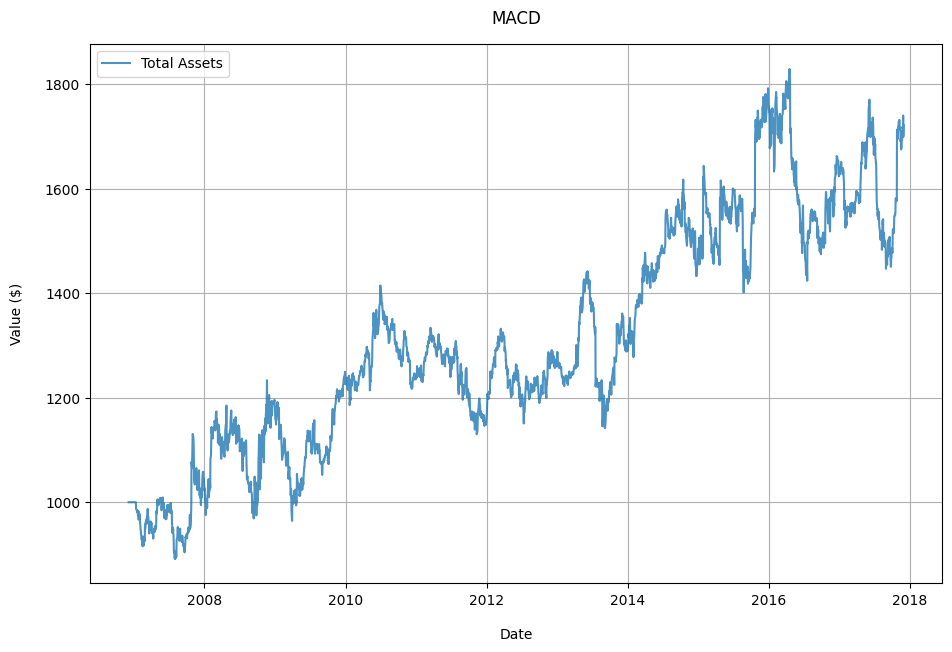

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.72172,0.890278,0.000196,-0.002957,-0.221681,-0.000885,28.572917,7.517912


In [5]:
MACD('MSFT', '2006-12-01', '2017-12-01', 1000)